In [1]:
from collections import defaultdict

import numpy as np
import pandas as pd
import pylab
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from time import clock, time
from datetime import datetime

from scipy.stats import mode
from scipy.stats import multivariate_normal as mvn

from sklearn import metrics  # too many functions to import, so import the whole module
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE, Isomap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale, label_binarize
from sklearn.svm import SVC

import plotly
import plotly.offline as py

plotly.offline.init_notebook_mode()

%matplotlib inline

In [2]:
plt.rcParams["font.size"] = 30
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.titlesize'] = 20
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 10

In [3]:
BASE_DIR = "."
DEBUG = False

np.random.seed(42)

In [4]:
def plot_3D(X, Y, title):
    scatter = {
        'mode': "markers",
        'name': "y",
        'type': "scatter3d",    
        'x': X[:,0], 
        'y': X[:,1], 
        'z': X[:,2],
        'marker': {'size':2, 'color':Y, 'colorscale':'Rainbow'}
    }
    fig = {'data':[scatter], 'layout': {'title':title}}
    py.iplot(fig)

# Digits  (Pen-Based Recognition of Handwritten Digits Data Set)

http://archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits

No need to download it as the data is readily available in "sklearn.datasets"

In [5]:
digits = load_digits()
digits

{'data': array([[  0.,   0.,   5., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,  10.,   0.,   0.],
        [  0.,   0.,   0., ...,  16.,   9.,   0.],
        ..., 
        [  0.,   0.,   1., ...,   6.,   0.,   0.],
        [  0.,   0.,   2., ...,  12.,   0.,   0.],
        [  0.,   0.,  10., ...,  12.,   1.,   0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'target_names': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'images': array([[[  0.,   0.,   5., ...,   1.,   0.,   0.],
         [  0.,   0.,  13., ...,  15.,   5.,   0.],
         [  0.,   3.,  15., ...,  11.,   8.,   0.],
         ..., 
         [  0.,   4.,  11., ...,  12.,   7.,   0.],
         [  0.,   2.,  14., ...,  12.,   0.,   0.],
         [  0.,   0.,   6., ...,   0.,   0.,   0.]],
 
        [[  0.,   0.,   0., ...,   5.,   0.,   0.],
         [  0.,   0.,   0., ...,   9.,   0.,   0.],
         [  0.,   0.,   3., ...,   6.,   0.,   0.],
         ..., 
         [  0.,   0.,   1., ...,   6.,   0.,   0.],
        

The digits.data and digits.images are identical. Both contain the pixel values of digits, only arranged in different formats (using "reshape" in numpy).

In [6]:
digits.target_names

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [7]:
print(digits.data.shape)

(1797, 64)


In [8]:
print(digits.images.shape)

(1797, 8, 8)


In [9]:
print(digits.target.shape)

(1797,)


In [10]:
# X = digits.images.reshape((len(digits.images), -1))

X = digits.data
I = digits.images
Y = digits.target
Y_names = digits.target_names

n_digits = len(Y_names)

n_samples, n_features = X.shape

print("n_digits=%d \t n_samples=%d \t n_features=%d" % (n_digits, n_samples, n_features))

n_digits=10 	 n_samples=1797 	 n_features=64


In [11]:
X.shape

(1797, 64)

In [12]:
I.shape

(1797, 8, 8)

In [13]:
df_Y = pd.DataFrame(Y, columns=["target"])
df_Y

target
0          0
1          1
2          2
3          3
4          4
5          5
6          6
7          7
8          8
9          9
10         0
11         1
12         2
13         3
14         4
15         5
16         6
17         7
18         8
19         9
20         0
21         1
22         2
23         3
24         4
25         5
26         6
27         7
28         8
29         9
...      ...
1767       4
1768       0
1769       5
1770       3
1771       6
1772       9
1773       6
1774       1
1775       7
1776       5
1777       4
1778       4
1779       7
1780       2
1781       8
1782       2
1783       2
1784       5
1785       7
1786       9
1787       5
1788       4
1789       8
1790       8
1791       4
1792       9
1793       0
1794       8
1795       9
1796       8

[1797 rows x 1 columns]

In [14]:
df_Y.describe()

target
count  1797.000000
mean      4.490818
std       2.865304
min       0.000000
25%       2.000000
50%       4.000000
75%       7.000000
max       9.000000

In [15]:
df_Y_counts = df_Y.groupby('target')
df_Y_counts.size()

target
0    178
1    182
2    177
3    183
4    181
5    182
6    181
7    179
8    174
9    180
dtype: int64

# Colors

Let's decide on a set of colors for digits (for comparison of charts)

Note: try different colormaps, see which one helps differentiate the plots of digits best.

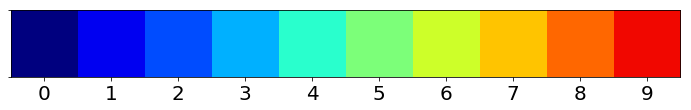

In [16]:
# pick the best
#cmap = plt.cm.get_cmap('YlOrRd')    # Sequential
#cmap = plt.cm.get_cmap('Paired')    # Categorical
#cmap = plt.cm.get_cmap('rainbow')   # Divergent, yellow in middle, has both green and red  
#cmap = plt.cm.get_cmap('Pastel2')   # Divergent
cmap = plt.cm.get_cmap('jet')        # Divergent

#colors = 10*['red', 'green', 'blue', 'yellow', 'cyan', 'magenta', 'gold', 'maroon', 'orange', 'purple']

# the following colors is consistent with the cmap defined above
colors = [cmap(i*0.1) for i in range(10)]

Y_colors = [colors[y] for y in Y]

# Visualize the colors 
plt.imshow([colors], extent=[0, 10, 0, 1])
ax = plt.gca()
ax.set_xticks(np.arange(0.5,10.5,step=1.0))
ax.set_xticklabels(Y_names)
ax.set_yticklabels([])
ax.grid(False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11286dcf8>]], dtype=object)

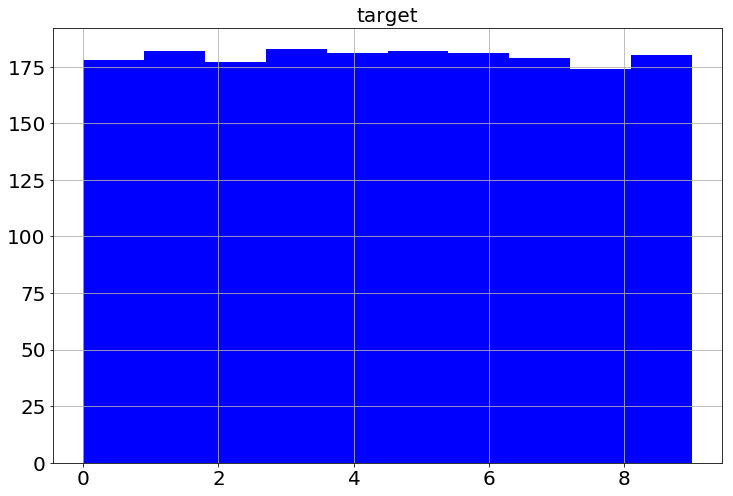

In [17]:
df_Y.hist(alpha=1.0, color="blue")

(0, 200)

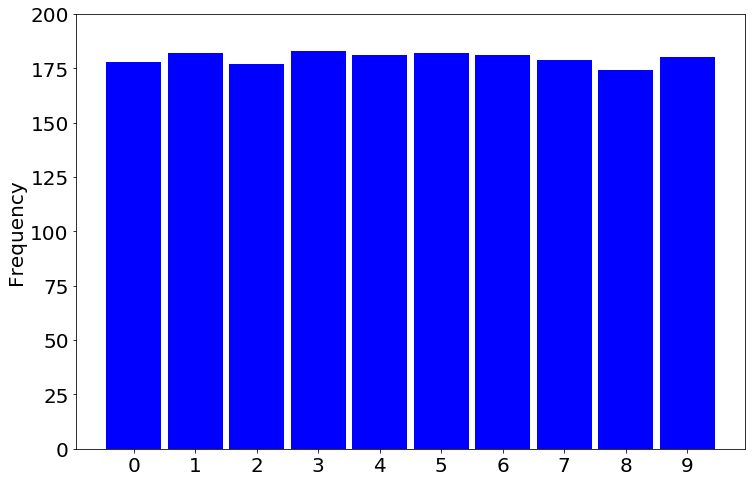

In [18]:
# "bins" defines the start and end points of bins
#ax = df_Y.plot(kind='hist',
ax = pd.Series(Y).plot(kind='hist', 
                       bins=[0,1,2,3,4,5,6,7,8,9,10], 
                       xticks=np.arange(0.5,10.5,step=1.0),
                       alpha=1.0, color="blue", rwidth=0.9)
#ax.set_xticks(np.arange(0.5,10.5,step=1.0))
ax.set_xticklabels((0,1,2,3,4,5,6,7,8,9))
ax.set_ylim(0,200)

#### Display one digit

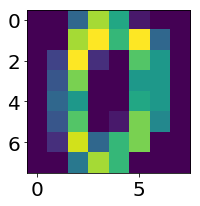

In [19]:
plt.figure(1, figsize=(3, 3))
plt.imshow(I[0], interpolation='nearest')
plt.show()

In [20]:
Y[0:50]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2,
       3, 4, 5, 6, 7, 8, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, 7, 7, 3,
       5, 1, 0, 0])

#### Display ten digits

8
4
1
7
7
3
5
1
0
0


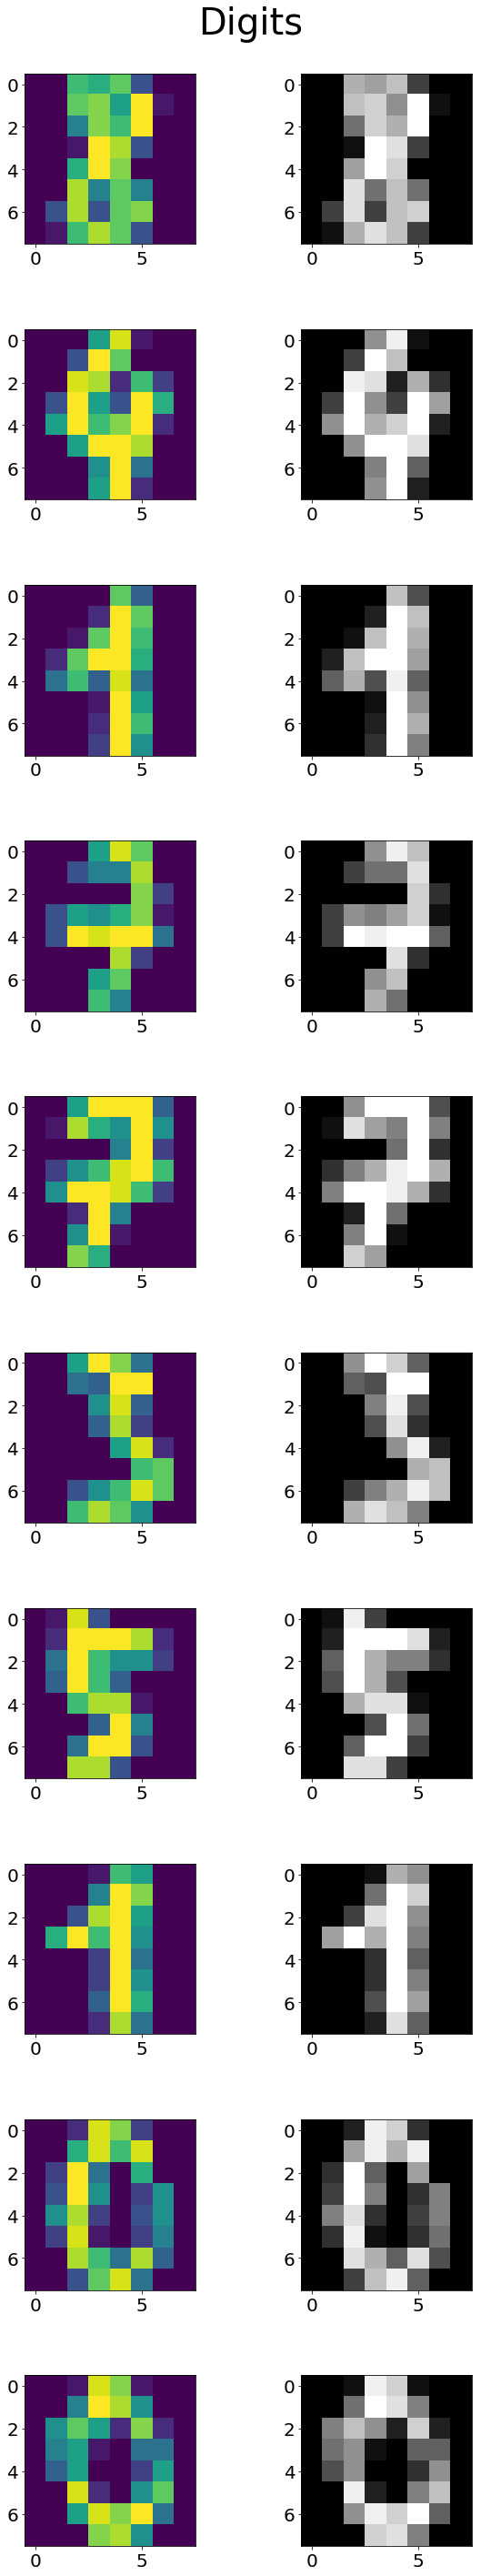

In [21]:
f, axes = plt.subplots(10, 2, figsize=(10,50))

plt.title('Digits', position=(-0.3,14.7), fontsize=40)

# The line below will put the title in exactly the same location as the above line
#axes[0, 0].set_title("Digits", fontsize=40, position=(1.32,1.2))

# Make subplots farther from each other
f.subplots_adjust(hspace=0.5, wspace=0.2)

for i in range(40,50):
    print(Y[i])
    axes[i%10, 0].imshow(I[i], cmap='viridis')
    axes[i%10, 1].imshow(I[i], cmap='gray')

Display the first 100 digits in the dataset

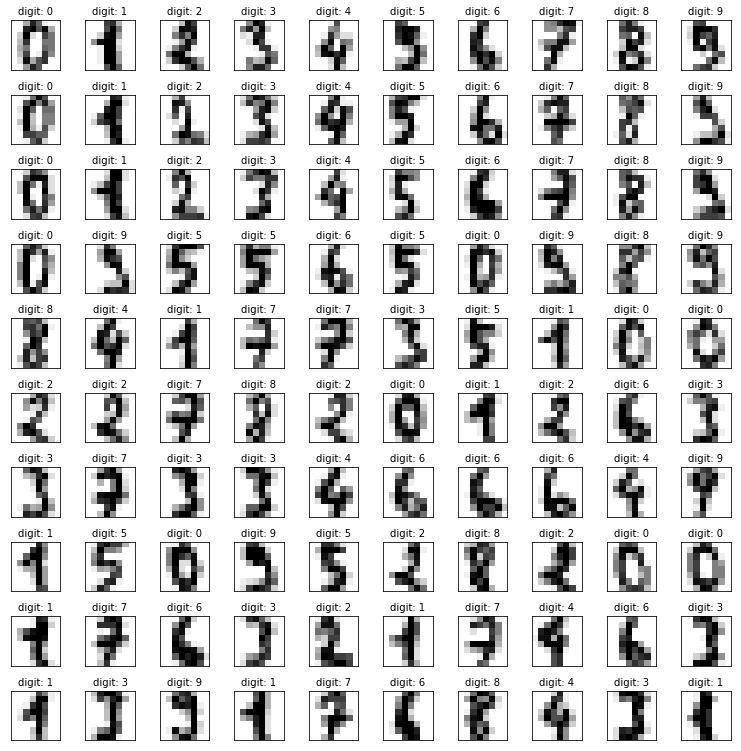

In [22]:
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.5, wspace=0.5)

for i, axi in enumerate(ax.flat):
    axi.imshow(I[i], cmap='binary')
    axi.set(xticks=[], yticks=[])
    
    axi.set_title("digit: %i" % Y[i], size=10)

So by just looking at the first 10 or 20 examples, you may think the dataset is ordered and periodic, however extending the set you are viewing will prove otherwise.

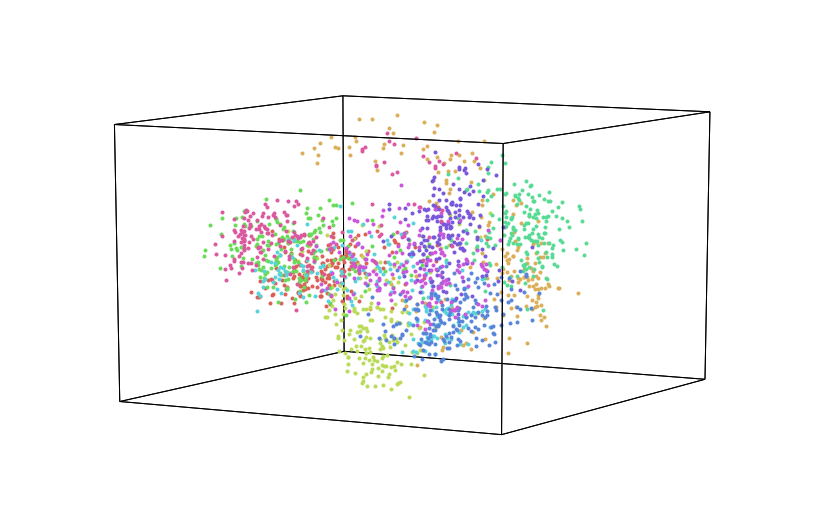

In [24]:
import hypertools as hyp
from numpy.core import multiarray

# Note: If you get the following error for multiarray, 
# try upgrading numpy using "pip3 install numpy --upgrade":
#
# RuntimeError                              Traceback (most recent call last)
# RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

hyp.plot(X, '.', hue=Y, colors=colors)

In [25]:
df_X = pd.DataFrame(X)
print(df_X)

       0    1     2     3     4     5     6    7    8     9  ...     54   55  \
0     0.0  0.0   5.0  13.0   9.0   1.0   0.0  0.0  0.0   0.0 ...    0.0  0.0   
1     0.0  0.0   0.0  12.0  13.0   5.0   0.0  0.0  0.0   0.0 ...    0.0  0.0   
2     0.0  0.0   0.0   4.0  15.0  12.0   0.0  0.0  0.0   0.0 ...    5.0  0.0   
3     0.0  0.0   7.0  15.0  13.0   1.0   0.0  0.0  0.0   8.0 ...    9.0  0.0   
4     0.0  0.0   0.0   1.0  11.0   0.0   0.0  0.0  0.0   0.0 ...    0.0  0.0   
5     0.0  0.0  12.0  10.0   0.0   0.0   0.0  0.0  0.0   0.0 ...    4.0  0.0   
6     0.0  0.0   0.0  12.0  13.0   0.0   0.0  0.0  0.0   0.0 ...    8.0  0.0   
7     0.0  0.0   7.0   8.0  13.0  16.0  15.0  1.0  0.0   0.0 ...    0.0  0.0   
8     0.0  0.0   9.0  14.0   8.0   1.0   0.0  0.0  0.0   0.0 ...    8.0  0.0   
9     0.0  0.0  11.0  12.0   0.0   0.0   0.0  0.0  0.0   2.0 ...    4.0  0.0   
10    0.0  0.0   1.0   9.0  15.0  11.0   0.0  0.0  0.0   0.0 ...    0.0  0.0   
11    0.0  0.0   0.0   0.0  14.0  13.0  

It looks like the first and the last columns are almost empty!

In [26]:
print(df_X[0])
print("sum=", df_X[0].sum())
print("sum=", sum(df_X[0]))

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
5       0.0
6       0.0
7       0.0
8       0.0
9       0.0
10      0.0
11      0.0
12      0.0
13      0.0
14      0.0
15      0.0
16      0.0
17      0.0
18      0.0
19      0.0
20      0.0
21      0.0
22      0.0
23      0.0
24      0.0
25      0.0
26      0.0
27      0.0
28      0.0
29      0.0
       ... 
1767    0.0
1768    0.0
1769    0.0
1770    0.0
1771    0.0
1772    0.0
1773    0.0
1774    0.0
1775    0.0
1776    0.0
1777    0.0
1778    0.0
1779    0.0
1780    0.0
1781    0.0
1782    0.0
1783    0.0
1784    0.0
1785    0.0
1786    0.0
1787    0.0
1788    0.0
1789    0.0
1790    0.0
1791    0.0
1792    0.0
1793    0.0
1794    0.0
1795    0.0
1796    0.0
Name: 0, Length: 1797, dtype: float64
sum= 0.0
sum= 0.0


In [27]:
X.shape, Y.shape

((1797, 64), (1797,))

In [28]:
All = np.hstack((X,Y.reshape(-1,1)))
df_All = pd.DataFrame(All)
df_All.columns = ["X"+str(i) for i in range(64)]+["Y"]
df_All.head()

X0   X1   X2    X3    X4    X5   X6   X7   X8   X9 ...   X55  X56  X57  \
0  0.0  0.0  5.0  13.0   9.0   1.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   
1  0.0  0.0  0.0  12.0  13.0   5.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   
2  0.0  0.0  0.0   4.0  15.0  12.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   
3  0.0  0.0  7.0  15.0  13.0   1.0  0.0  0.0  0.0  8.0 ...   0.0  0.0  0.0   
4  0.0  0.0  0.0   1.0  11.0   0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   

   X58   X59   X60   X61  X62  X63    Y  
0  6.0  13.0  10.0   0.0  0.0  0.0  0.0  
1  0.0  11.0  16.0  10.0  0.0  0.0  1.0  
2  0.0   3.0  11.0  16.0  9.0  0.0  2.0  
3  7.0  13.0  13.0   9.0  0.0  0.0  3.0  
4  0.0   2.0  16.0   4.0  0.0  0.0  4.0  

[5 rows x 65 columns]

In [29]:
df_All_corr = df_All.corr()
df_All_corr

X0        X1        X2        X3        X4        X5        X6        X7  \
X0  NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
X1  NaN  1.000000  0.556618  0.207814 -0.018761  0.060776  0.048388 -0.038927   
X2  NaN  0.556618  1.000000  0.560180 -0.084235  0.043569  0.002841 -0.062278   
X3  NaN  0.207814  0.560180  1.000000  0.023938 -0.171377 -0.115732 -0.040139   
X4  NaN -0.018761 -0.084235  0.023938  1.000000  0.507731  0.127764  0.010065   
X5  NaN  0.060776  0.043569 -0.171377  0.507731  1.000000  0.607309  0.154095   
X6  NaN  0.048388  0.002841 -0.115732  0.127764  0.607309  1.000000  0.487961   
X7  NaN -0.038927 -0.062278 -0.040139  0.010065  0.154095  0.487961  1.000000   
X8  NaN  0.032320  0.022311  0.035663  0.042065  0.000189 -0.024205 -0.007386   
X9  NaN  0.556372  0.582259  0.328344  0.051657  0.038540 -0.042377 -0.058368   
X10 NaN  0.224522  0.631467  0.596480  0.013998  0.072170 -0.004999 -0.043370   
X11 NaN -0.109056 -0.286026 -0.002440 -0.135715 -0.199340  0.004815  0.061640   
X12 NaN  0.027908  0.028798 -0.068626  0.160268 -0.052195 -0.074206 -0.028066   
X13 NaN -0.063983  0.063248  0.023163  0.390035  0.539509  0.193017  0.034496   
X14 NaN -0.029973 -0.089221 -0.178804  0.133625  0.534550  0.730296  0.415125   
X15 NaN -0.043697 -0.100526 -0.113830  0.014505  0.109110  0.365145  0.711073   
X16 NaN -0.005109 -0.016943  0.022736  0.009911 -0.025065 -0.018284 -0.005579   
X17 NaN  0.213586  0.278864  0.187811  0.036612  0.069124 -0.031534 -0.068761   
X18 NaN -0.113581 -0.084251  0.040516 -0.124452 -0.051834  0.026008 -0.010793   
X19 NaN -0.105882 -0.310726 -0.360440 -0.155501 -0.194924 -0.082380 -0.020563   
X20 NaN  0.096254  0.208726  0.067943 -0.029025 -0.079119 -0.154731 -0.079767   
X21 NaN -0.170070 -0.086630 -0.018315  0.182671  0.212117  0.064161  0.022961   
X22 NaN -0.131330 -0.217657 -0.224892  0.078333  0.160092  0.296929  0.308593   
X23 NaN -0.038266 -0.118925 -0.149758  0.023887 -0.005235  0.121535  0.283088   
X24 NaN -0.011183 -0.036549 -0.002639  0.008971 -0.022284 -0.013676 -0.004173   
X25 NaN -0.085911 -0.153100 -0.109260  0.027043  0.035104 -0.002435 -0.053977   
X26 NaN -0.146383 -0.310519 -0.256293 -0.063194 -0.042422  0.016022 -0.025507   
X27 NaN  0.072981  0.108378 -0.057108  0.036231  0.102088  0.021153 -0.051673   
X28 NaN  0.041083  0.199761  0.090178  0.089654  0.155958  0.037512 -0.029315   
X29 NaN -0.206318 -0.193759 -0.183257  0.122548  0.161788  0.137753  0.117490   
..   ..       ...       ...       ...       ...       ...       ...       ...   
X35 NaN  0.044139 -0.055715  0.017606  0.026593 -0.015156  0.024445 -0.001518   
X36 NaN -0.059858 -0.120387 -0.077963  0.069915  0.083900  0.083791  0.035977   
X37 NaN -0.235776 -0.279790 -0.226493  0.089086  0.070963  0.086085  0.069542   
X38 NaN -0.173245 -0.183321 -0.037223  0.051408 -0.083352 -0.052013 -0.003014   
X39 NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
X40 NaN -0.020551 -0.067167 -0.099624  0.023642 -0.032832 -0.025134 -0.007669   
X41 NaN -0.124267 -0.268728 -0.257836 -0.018364 -0.163588 -0.119649 -0.046803   
X42 NaN -0.142999 -0.341944 -0.102203 -0.095154 -0.334563 -0.230843 -0.069565   
X43 NaN  0.024242 -0.157470 -0.025302 -0.037575 -0.168360 -0.046226  0.003320   
X44 NaN -0.054716 -0.203247 -0.243829  0.051713  0.118355  0.163509  0.079433   
X45 NaN -0.163272 -0.189976 -0.214744  0.074574  0.023182 -0.053468 -0.065505   
X46 NaN -0.086466 -0.069215  0.089703 -0.090120 -0.254044 -0.225019 -0.090632   
X47 NaN -0.025736 -0.064782  0.046919 -0.039530 -0.084500 -0.036360 -0.011095   
X48 NaN -0.011871 -0.038797 -0.062799  0.024149 -0.009702 -0.012059 -0.004430   
X49 NaN  0.225775  0.205796  0.015447 -0.020577 -0.044672 -0.045028 -0.048919   
X50 NaN  0.115281  0.262176  0.299762 -0.165601 -0.298908 -0.272282 -0.130473   
X51 NaN  0.020382 -0.042531  0.279420 -0.043649 -0.163489 -0.061658  0.004042   
X52 NaN  0.031455 -0.051530 -0.18053

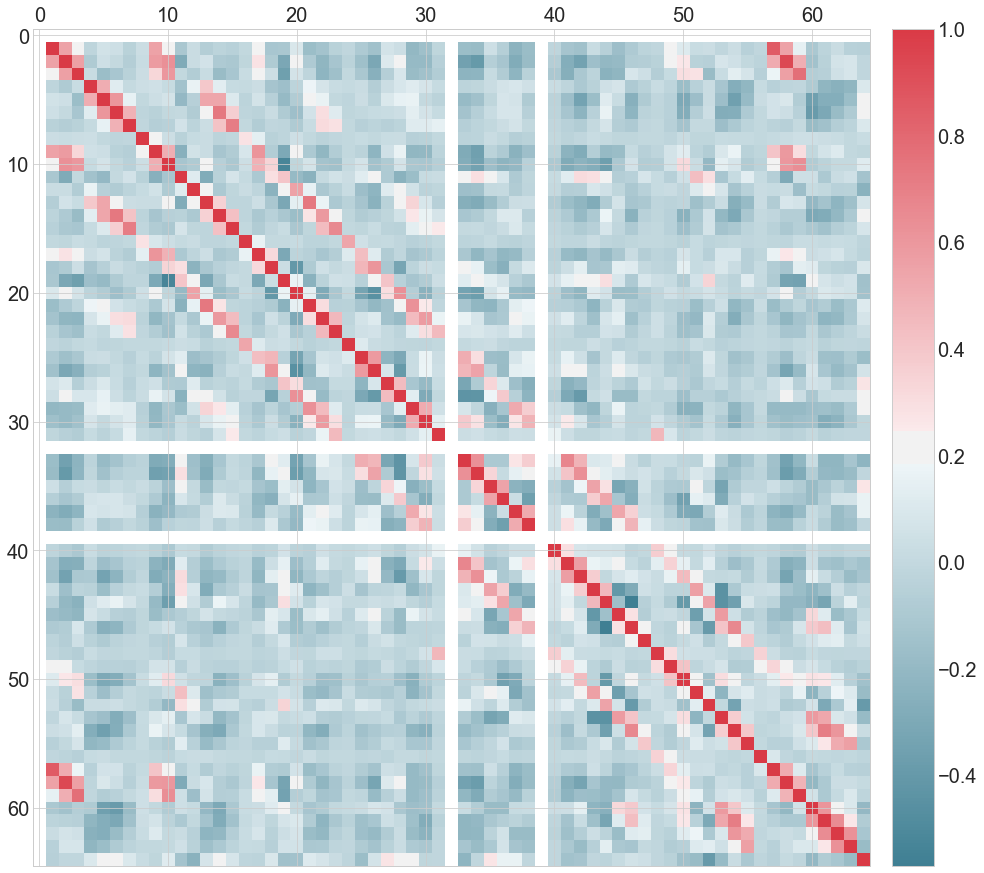

In [30]:
plt.figure(figsize=(20, 15))
plt.matshow(df_All_corr,
#           cmap=plt.cm.get_cmap('YlOrRd'),
            cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fignum=1)
plt.colorbar(fraction=0.05, pad=0.02)
plt.show()

For detailed analysis, you may show the index numbers of the digits data array

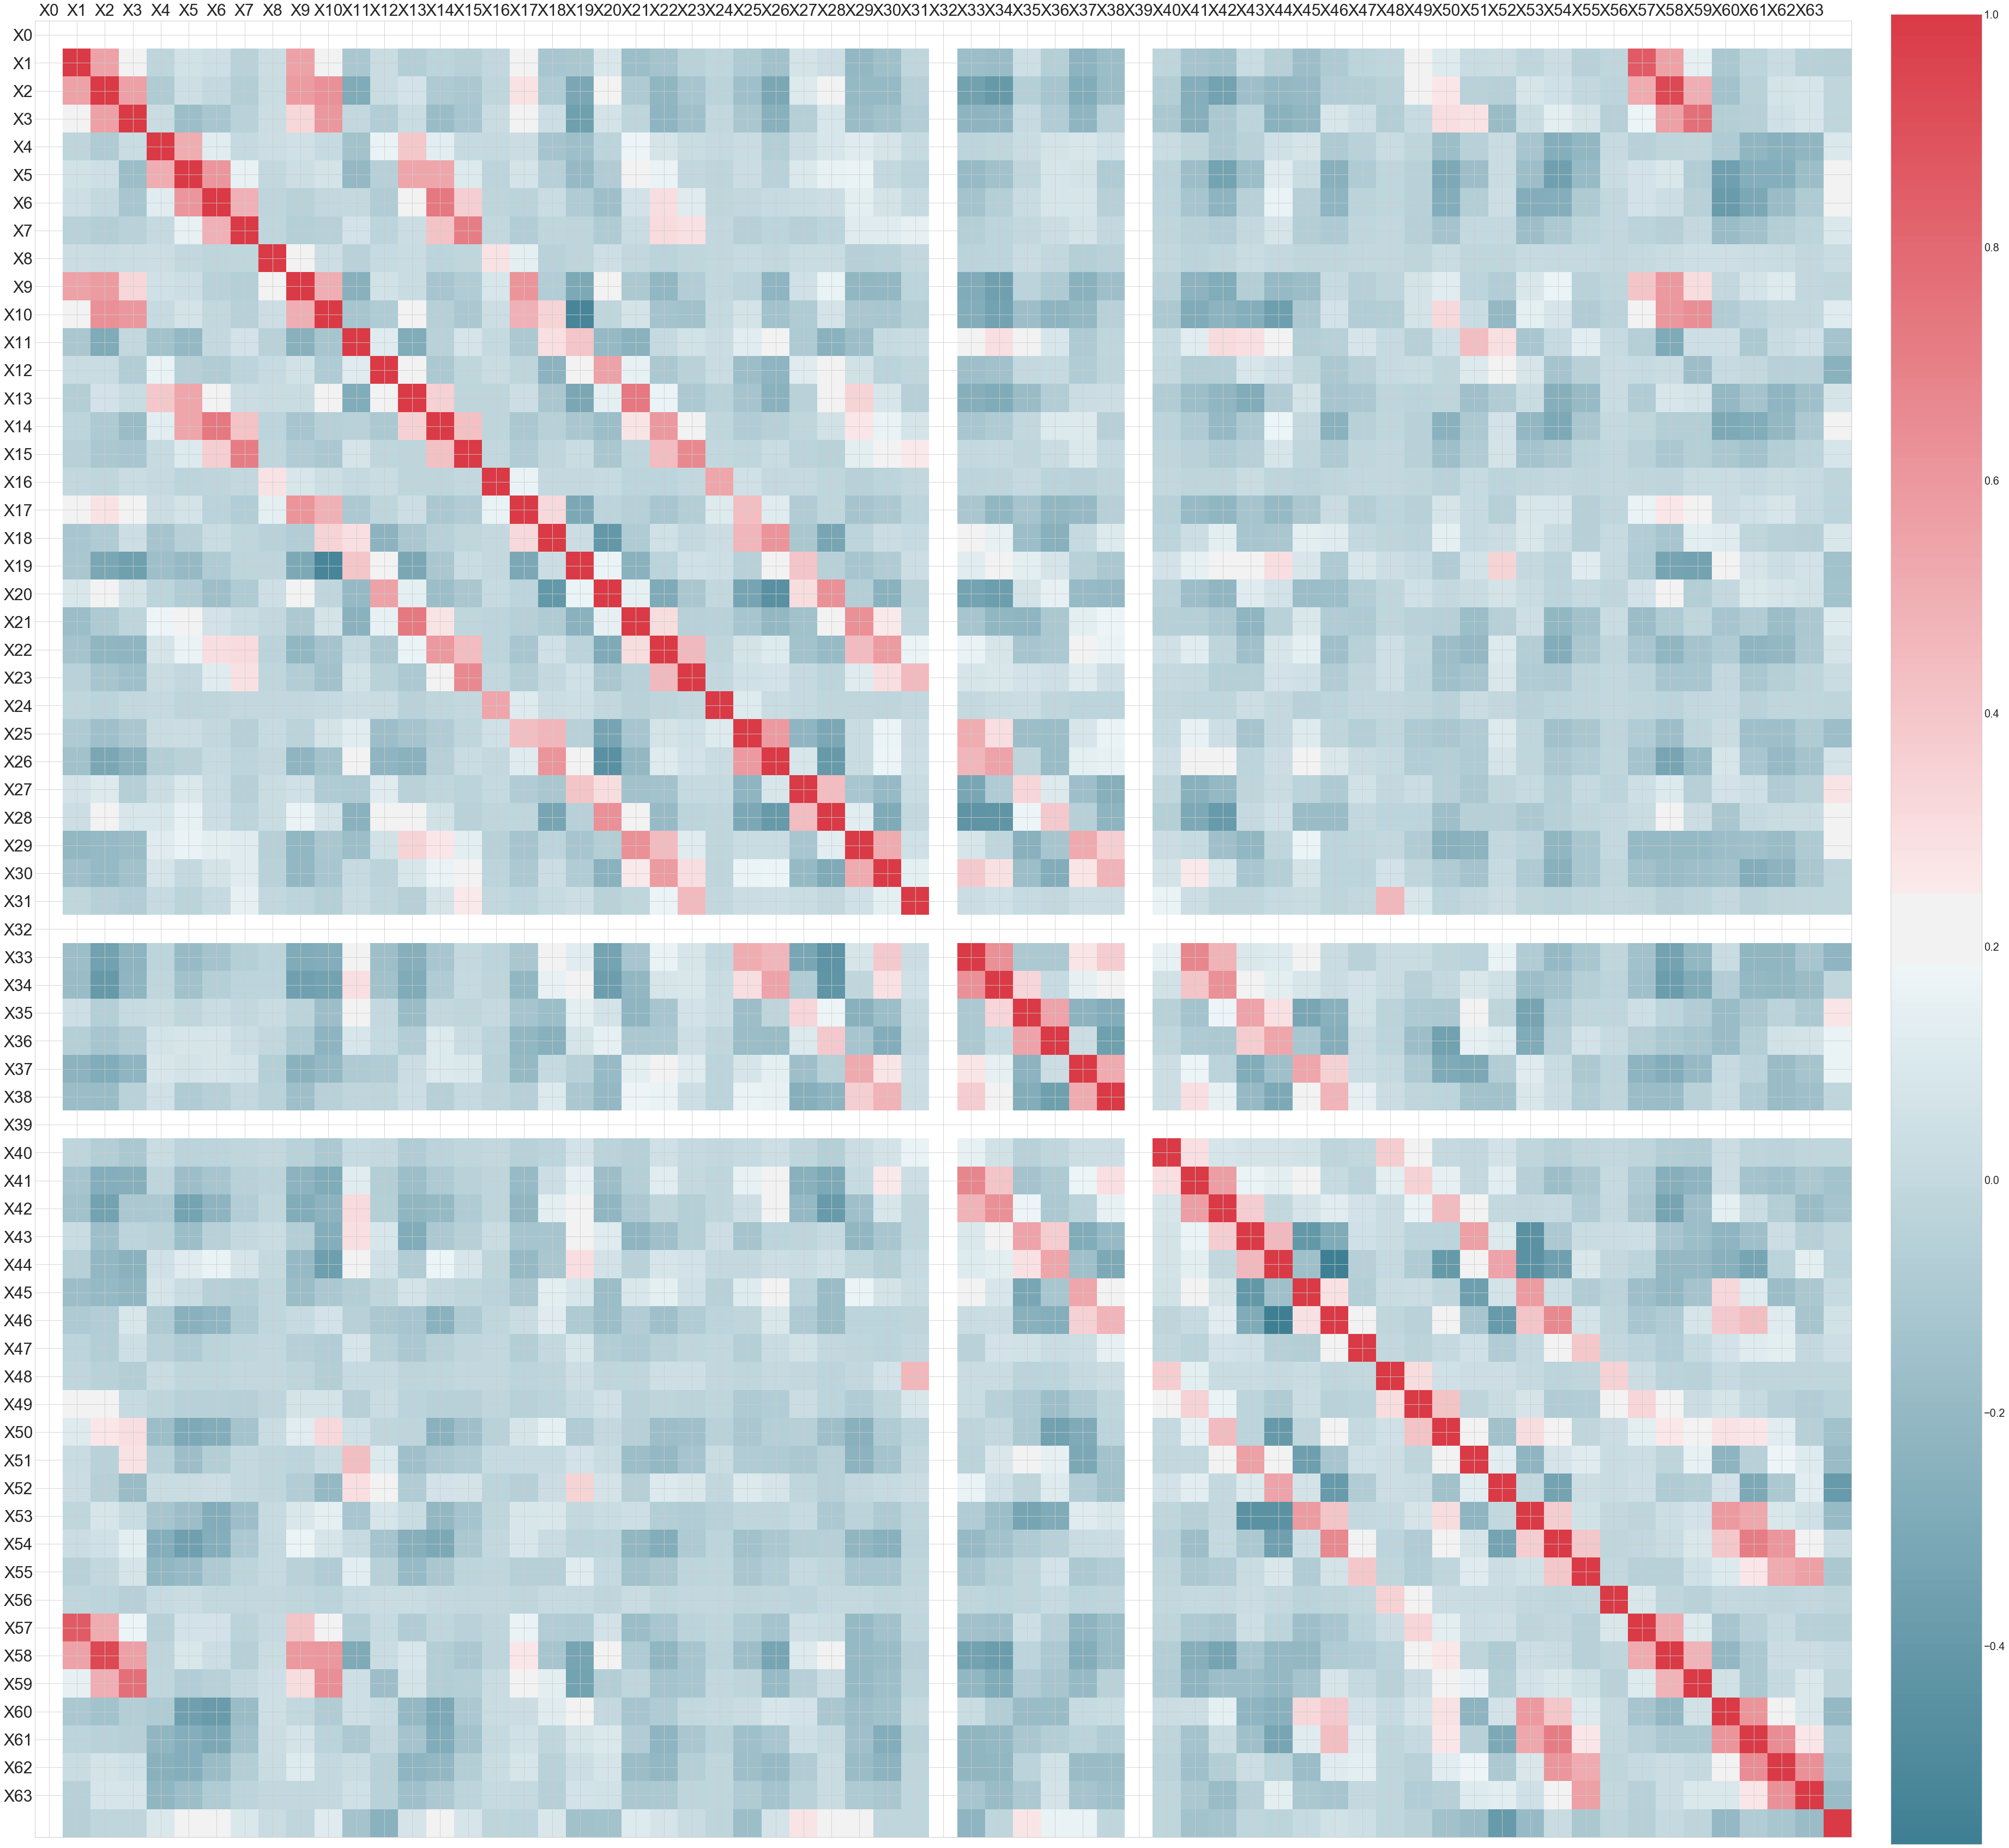

In [31]:
plt.figure(figsize=(n_features,n_features))
plt.matshow(df_All_corr,
#           cmap=plt.cm.get_cmap('YlOrRd'),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            fignum=1)
plt.xticks(range(n_features), df_All_corr.columns, fontsize=30)
plt.yticks(range(n_features), df_All_corr.columns, fontsize=30)
plt.colorbar(fraction=0.047, pad=0.02)
plt.show()

scatter_matrix for every index pair will take a long time and space. Also, the figures will be to small to be able ot observe anything clearly. So we can do it in smaller ranges of columns.

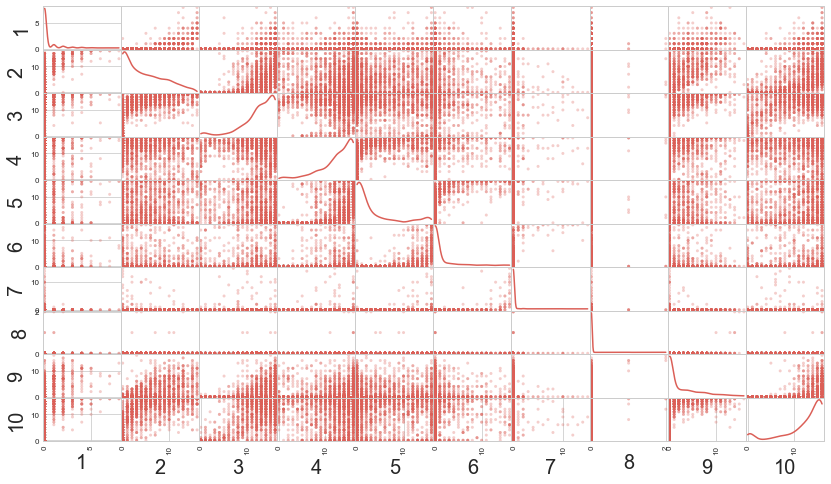

In [32]:
#pd.plotting.scatter_matrix(df_X, alpha = 0.3, figsize = (14,8), diagonal = 'kde')
df_X_first_ten_columns = df_X.loc[:,1:10]
pd.plotting.scatter_matrix(df_X_first_ten_columns, alpha = 0.3, figsize = (14,8), diagonal = 'kde')
plt.show()

The diagonal shows the distribution of the variable

Let's try the same things with the seaborn package.

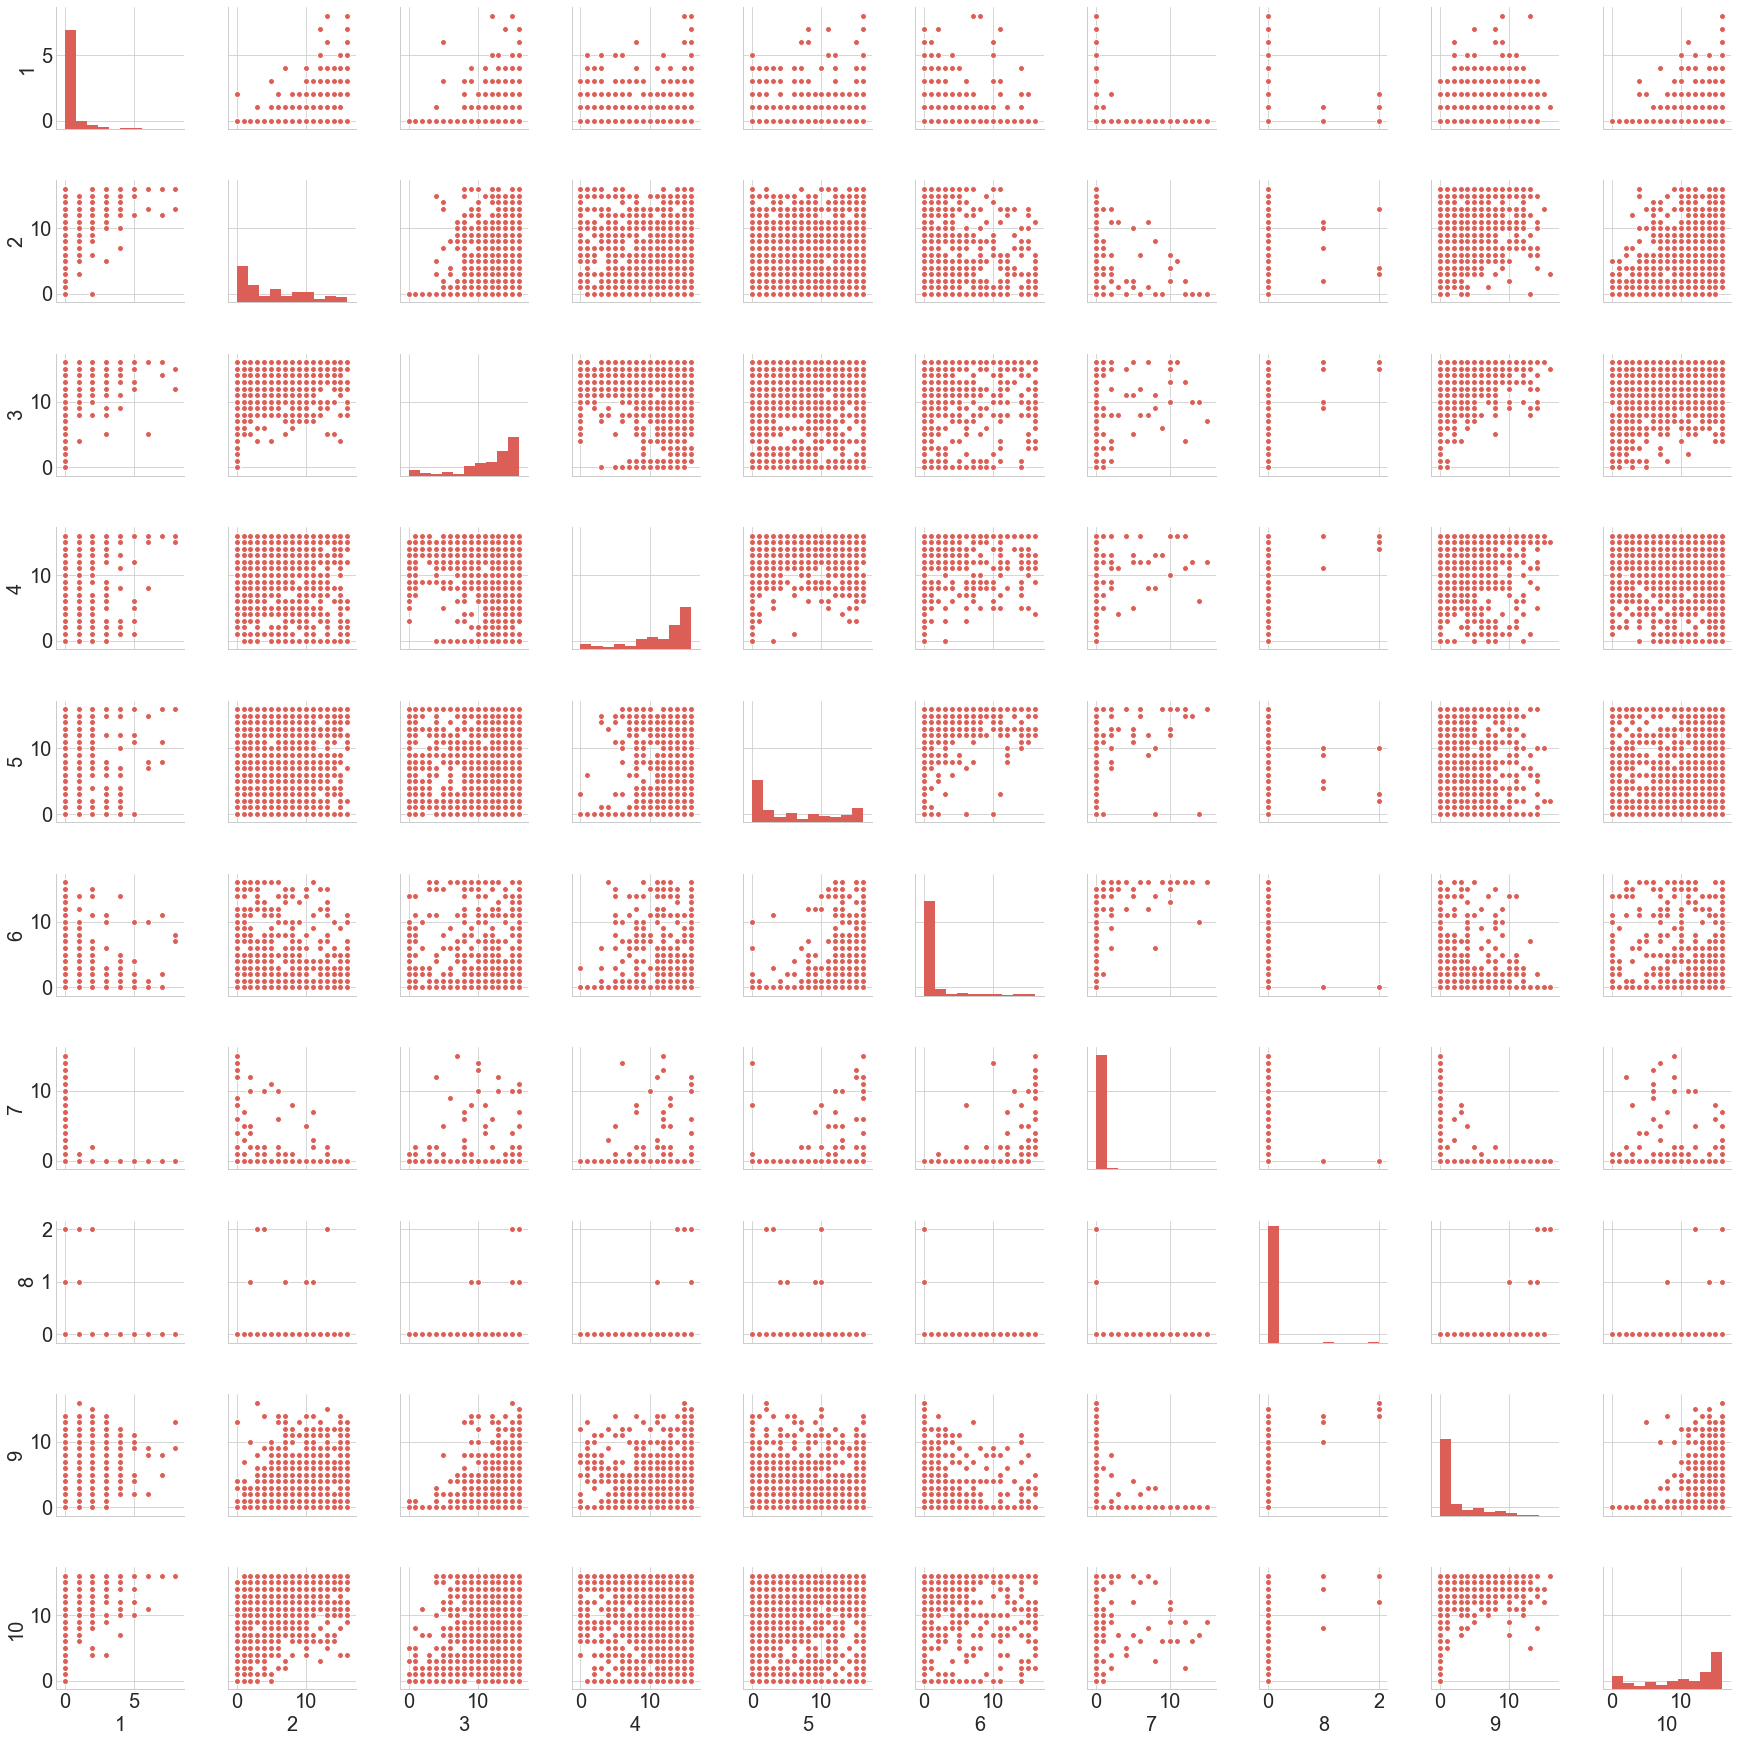

In [33]:
sns.pairplot(df_X_first_ten_columns)

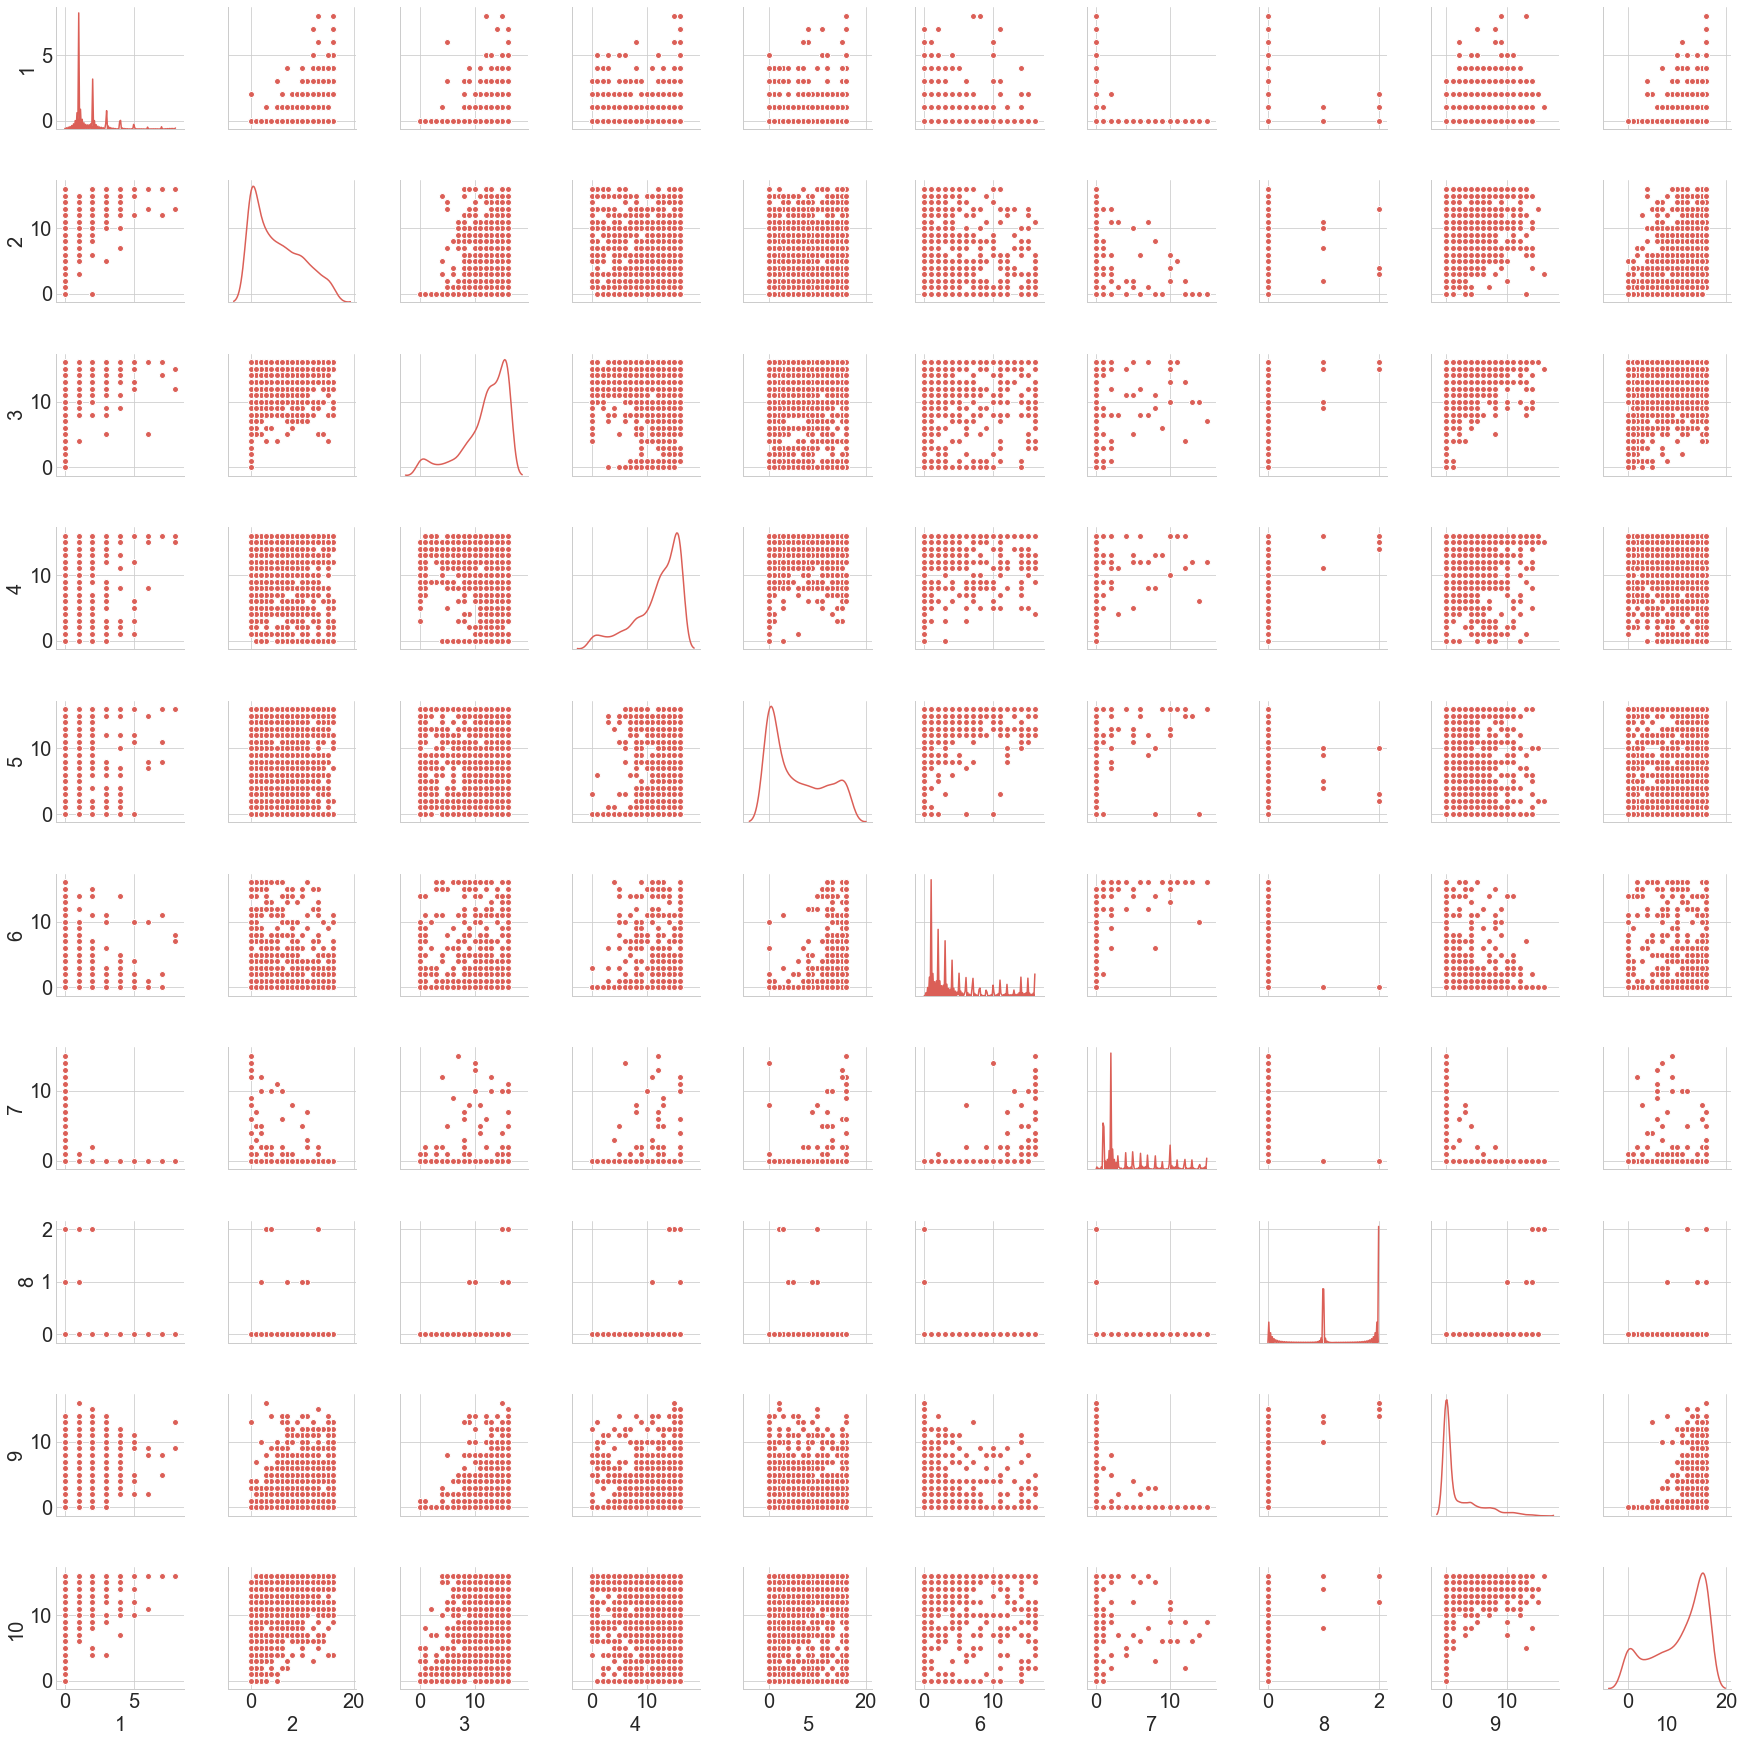

In [34]:
sns.pairplot(df_X_first_ten_columns, diag_kind="kde")

Try different fonts sizes and colormaps in the following heatmap

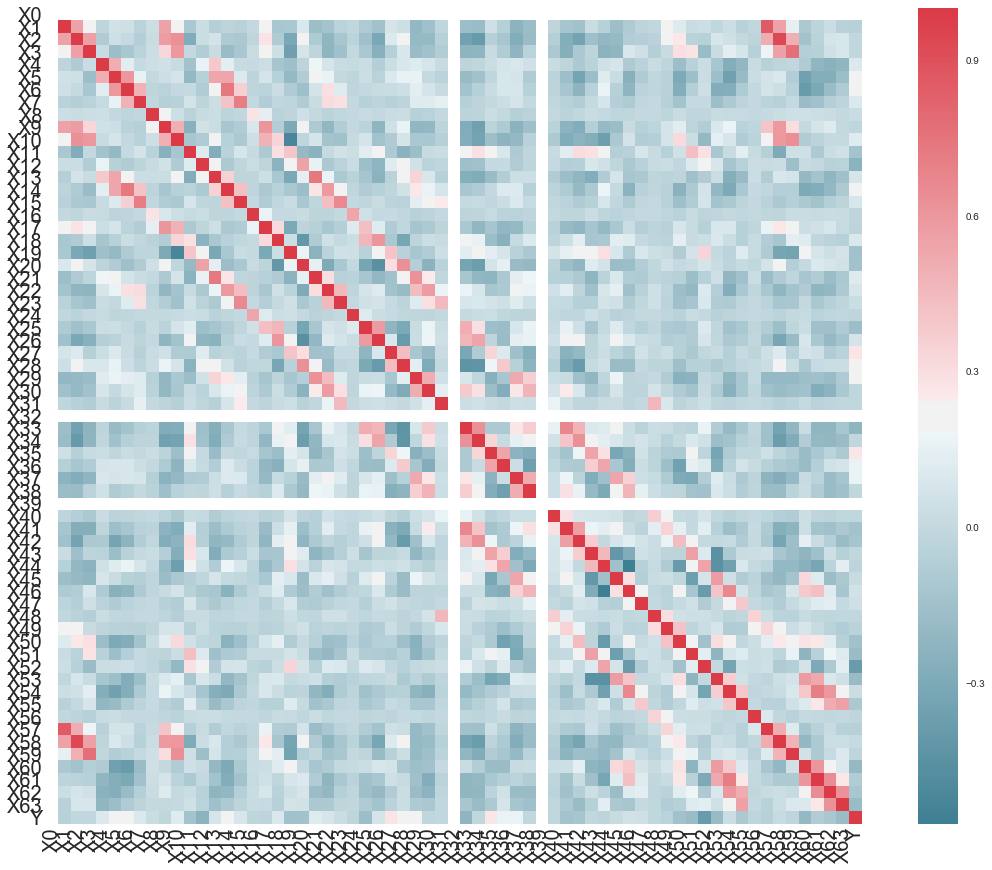

In [35]:
f, ax = plt.subplots(figsize=(20, 15))
sns.set(font_scale=1.0)
sns.heatmap(df_All_corr,
            mask=np.zeros_like(df_All_corr, dtype=np.bool), 
#            cmap=plt.cm.get_cmap('YlOrRd'),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            xticklabels=df_All_corr.columns.values,
            yticklabels=df_All_corr.columns.values,
            square=True,
            ax=ax)

The heatmap is symmetric, so it is enough to draw the cells only below (or above) the diagonal:

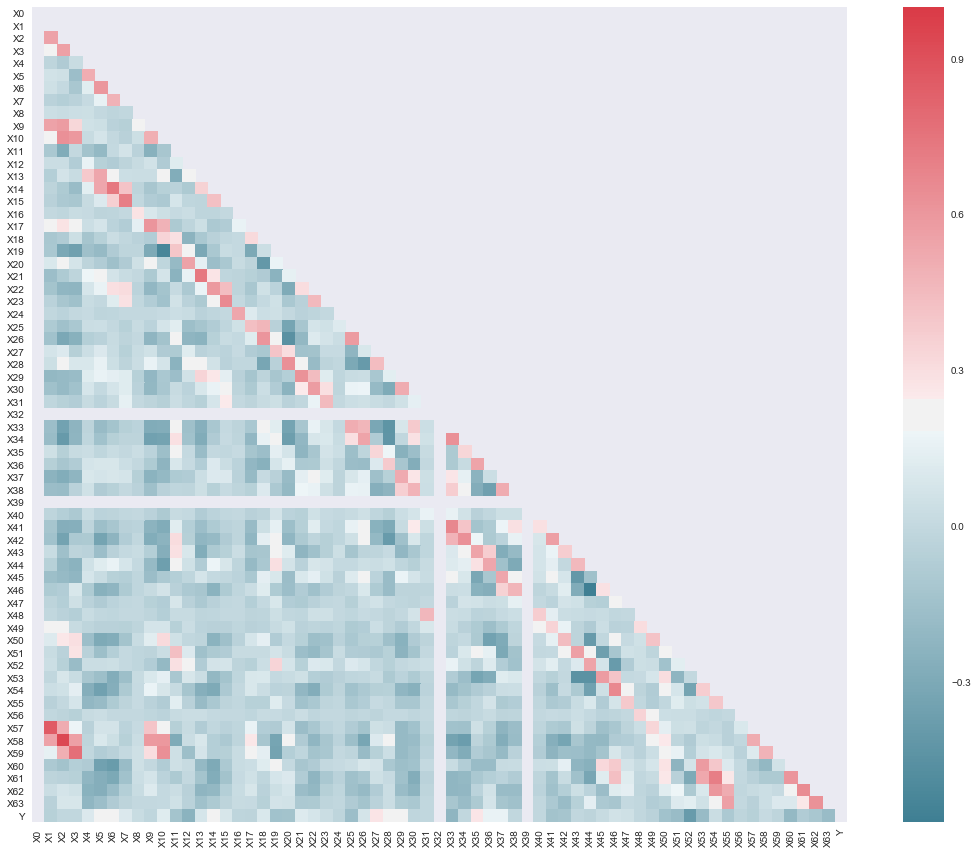

In [36]:
f, ax = plt.subplots(figsize=(20, 15))
sns.set(font_scale=1.0)
mask=np.zeros_like(df_All_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_All_corr,
            mask=mask, 
#            cmap=plt.cm.get_cmap('YlOrRd'),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            xticklabels=df_All_corr.columns.values,
            yticklabels=df_All_corr.columns.values,
            square=True,
            ax=ax)

Let's cluster similar indices together (compare the below plot with the one above)

In [37]:
indices = ["X"+str(i) for i in range(1,32)]
indices.extend(["X"+str(i) for i in range(33,39)])
indices.extend(["X"+str(i) for i in range(40,64)])
print(indices)

['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63']


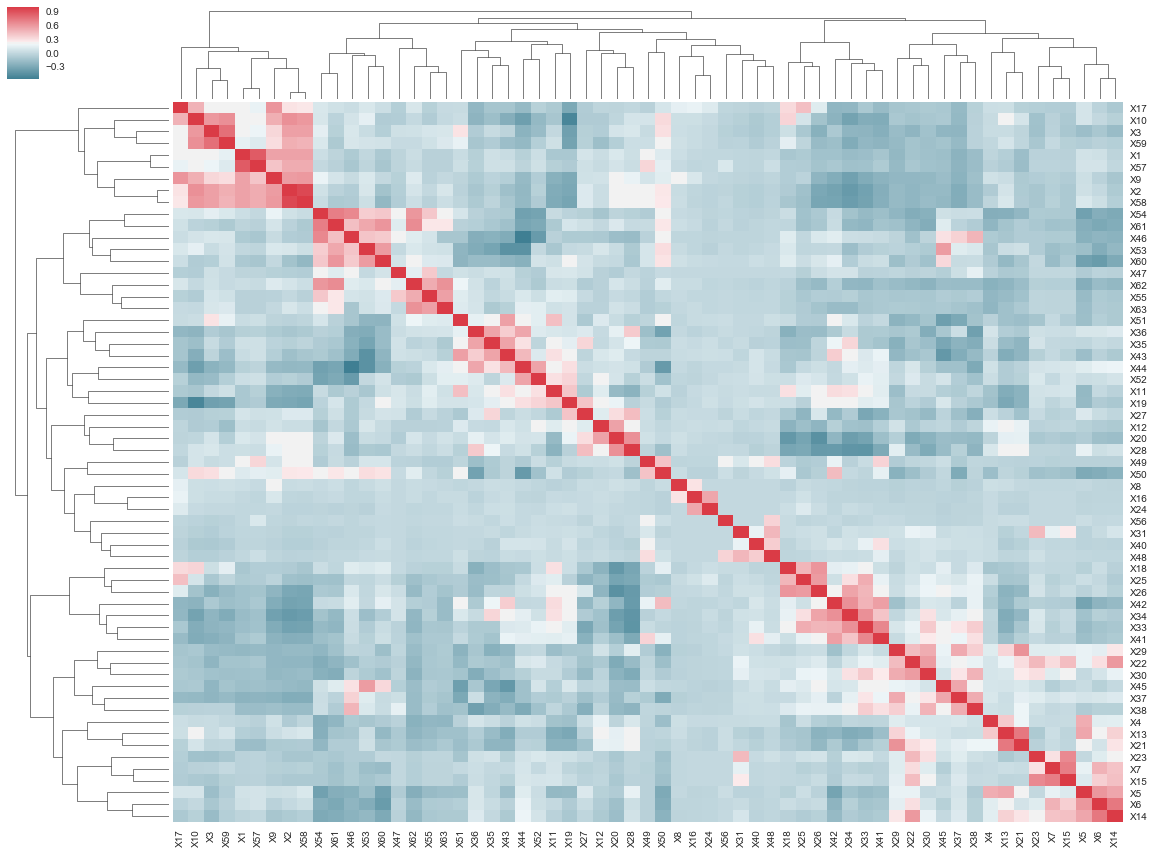

In [38]:
sns.clustermap(data=df_All_corr.loc[indices,indices], 
               #annot=True,
               cmap = sns.diverging_palette(220, 10, as_cmap=True), 
               #annot_kws={"size": 16},
               figsize=(20, 15))

Let's check how "Y" values change with "X30" :

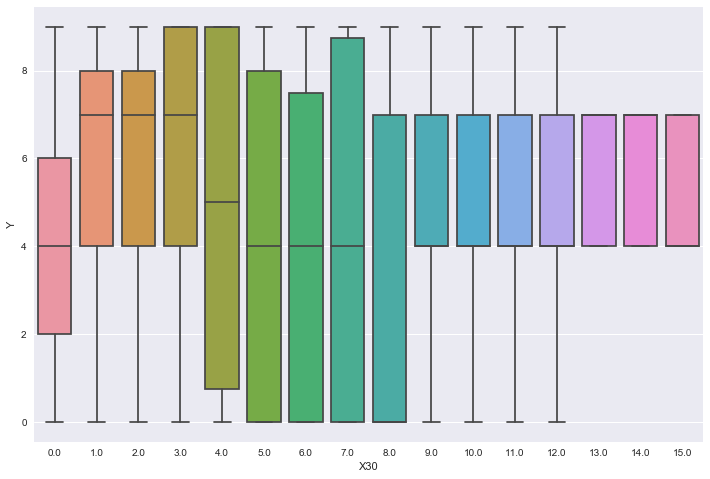

In [39]:
sns.boxplot(x="X30", y="Y", data=df_All)

We can also view how "X30" values change with "Y" :

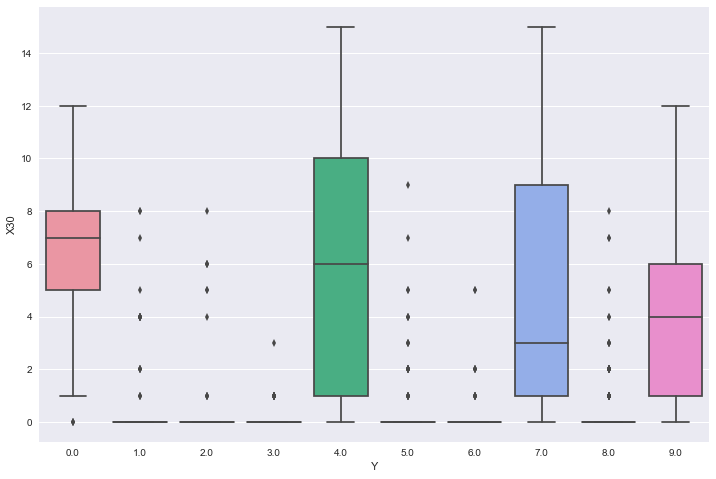

In [40]:
sns.boxplot(x="Y", y="X30", data=df_All)

Let's view the above relations using violin plot:

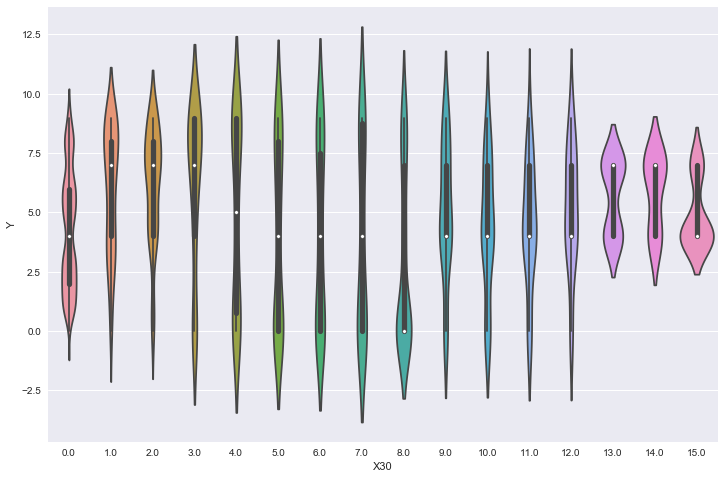

In [41]:
sns.violinplot(x="X30", y="Y", data=df_All)

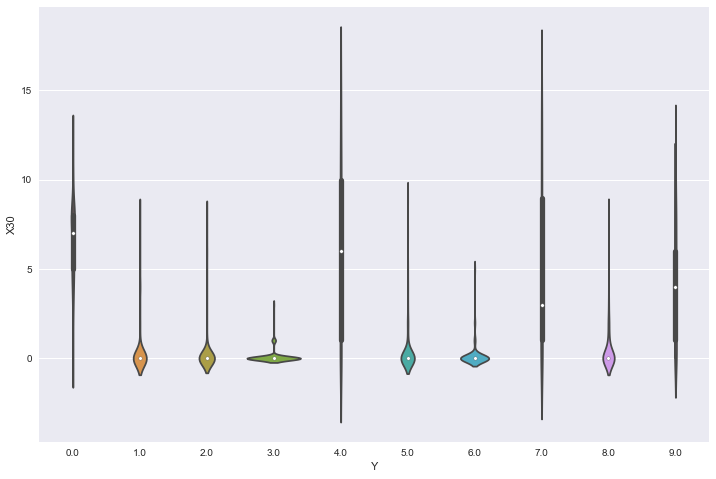

In [42]:
sns.violinplot(x="Y", y="X30", data=df_All)

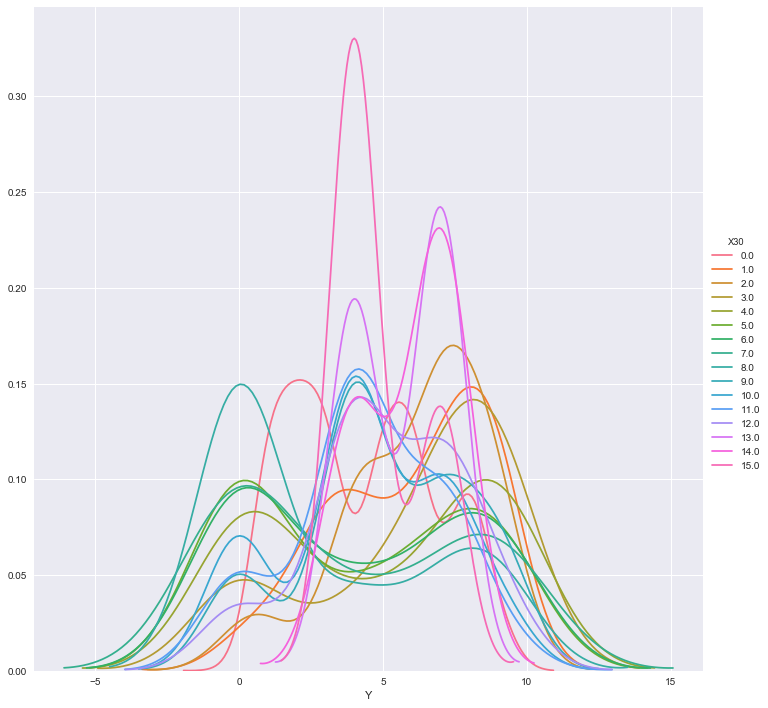

In [43]:
sns.FacetGrid(df_All, hue="X30", size=10) \
   .map(sns.kdeplot, "Y") \
   .add_legend()